In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shopping_simulator.simulator import LossSimulation

In [2]:
# This is the basic example of how to use the package. For a given set of product characteristics, we can calculate the minimum loss (the sum of the waste + (1 - availability) and the standard deviation of this loss.

simulation = LossSimulation(
    codelife=3,
    unit_sales_per_day=5,
    units_per_case=4,
    lead_time=3,
    seed=42
)

min_loss, min_loss_std =simulation.calculate_min_loss_and_variance(total_days=20000)

print(min_loss, min_loss_std)

0.10368693243374374 0.006730205920992612


In [3]:
# And understanding of the uncertainty is important, as there's inherently lots of uncertainty in the underlying simulation. We can generally resolve this by running for a larger number of days.

# Under the hood, the package simulates what happens when ordering decisions are made for a variety of stockout thresholds - i.e. what's the acceptable probability of a stockout. We can get closer to this by trying to identify the minimum loss.

res = simulation.calculate_min_loss(total_days = 2000)

In [4]:
# res is a Pydantic object that contains more information about the underlying simulation. 
print(res.min_loss, res.min_availability_loss, res.min_waste_loss)
print(res.model_dump_json(indent=2))

0.10911646586345382 0.08 0.029116465863453816
{
  "min_loss": 0.10911646586345382,
  "min_waste_loss": 0.029116465863453816,
  "min_availability_loss": 0.08,
  "min_stockout_threshold": 0.11100088888888889,
  "mean_units_sold_per_day": 4.97,
  "mean_eod_units": 20.62,
  "thresholds": [
    1e-6,
    0.11100088888888889,
    0.22200077777777777,
    0.3330006666666666,
    0.4440005555555555,
    0.5550004444444444,
    0.6660003333333333,
    0.7770002222222222,
    0.8880001111111111,
    0.999
  ],
  "loss": [
    0.25646198830409356,
    0.10911646586345382,
    0.15789256198347107,
    0.20483050847457626,
    0.2530263157894737,
    0.32152073732718894,
    0.4537688442211055,
    0.575,
    0.5163020833333334,
    0.8374999999999999
  ],
  "availability_loss": [
    0.005,
    0.08,
    0.13,
    0.19,
    0.23,
    0.31,
    0.45,
    0.575,
    0.515,
    0.83
  ],
  "waste_loss": [
    0.25146198830409355,
    0.029116465863453816,
    0.027892561983471075,
    0.0148305084745

In [5]:
# This is still doing loads of simulations in the background. If we want to get even closer to what's happening, then we can do an individual simulation.

res = simulation.simulate(total_days = 20, stockout_threshold = 0.4, verbose = 2)

# The output, because we've set verbose to 2, is a bit more detailed.
# The first line can be read as follows: [number of units (by group)], [days left (for each group)], probability of stockout in lead time + 1 days.
# Have a look at the object returned, try plotting some of the results.

No active groups at end of lead time

Day 0 [12] [3] 1
Day 0 Active Groups: [0]
Sales today: 7
Day 0 Wasted Units: 0
Day 0 Stockout: False

Day 1 [5 8] [2 5] 0.7797793533982622
Day 1 Active Groups: [0]
Sales today: 6
Day 1 Wasted Units: 0
Day 1 Stockout: True

Day 2 [8 4] [4 5] 0.7999886820755968
Day 2 Active Groups: []
Sales today: nothing to sell
Day 2 Wasted Units: 0
Day 2 Stockout: True

Day 3 [8 4 4] [3 4 5] 0.8763606433545758
Day 3 Active Groups: [0]
Sales today: 9
Day 3 Wasted Units: 0
Day 3 Stockout: True

Day 4 [4 4 4] [3 4 5] 0.970488310184541
Day 4 Active Groups: [0]
Sales today: 8
Day 4 Wasted Units: 0
Day 4 Stockout: True

Day 5 [4 4 8] [3 4 5] 0.6988326957333479
Day 5 Active Groups: [0]
Sales today: 4
Day 5 Wasted Units: 0
Day 5 Stockout: True

Day 6 [4 8 4] [3 4 5] 0.7869267137023676
Day 6 Active Groups: [0]
Sales today: 5
Day 6 Wasted Units: 0
Day 6 Stockout: True

Day 7 [8 4 4] [3 4 5] 0.8763606433545758
Day 7 Active Groups: [0]
Sales today: 4
Day 7 Wasted Units: 0
Day

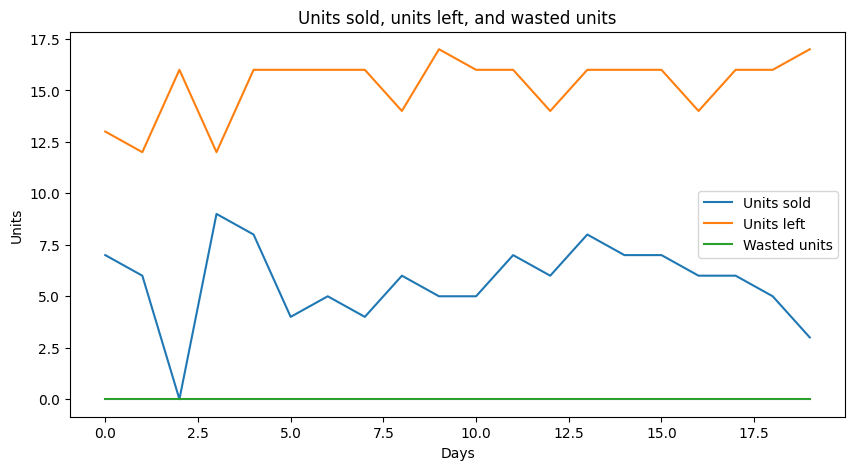

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(res.units_sold, label="Units sold")
ax.plot(res.eod_units, label="Units left")
ax.plot(res.wasted_units, label="Wasted units")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Units")
ax.set_title("Units sold, units left, and wasted units")
plt.show()

## A few example analyses

The `shopping_simulator` package has been developed to allow us to explore the theoretical impact of different product conditions, and their effect on the overall loss in that scenario. The results below indicate some areas where they can be used. It is by no means comprehensive, but hopefully useful as a tool to explore. I should note that due to the stochastic nature of the underlying simulation, the underlying trends can often be noisy.

### Impact of unit_sales_per_day on loss
Inuitively, the more units sold per day, the lower loss we'd expect. This is because we're selling more units, and can therefore have more of them in stock as a result. As the demand becomes larger the overall variance in demand is a smaller fraction of the total demand so it's easier to manage.

In [7]:
# Define the parameters of the simulation, let's take a classic example in fresh produce.
codelife = 3
unit_sales_per_day_array = np.arange(1, 13) # note the simulation gets very slow for large unit_sales_per_day, sorry
units_per_case = 6
lead_time = 3

# Define how many days we're going to simulate for. Reduce the number of days to speed up the simulation.
total_days = 1000

min_loss = np.zeros(len(unit_sales_per_day_array))
min_loss_std = np.zeros(len(unit_sales_per_day_array))

for i, unit_sales_per_day in enumerate(unit_sales_per_day_array):
    print(f"Unit sales per day: {unit_sales_per_day}")
    simulation = LossSimulation(
        codelife=codelife,
        unit_sales_per_day=unit_sales_per_day,
        units_per_case=units_per_case,
        lead_time=lead_time,
    )

    min_loss[i], min_loss_std[i] = simulation.calculate_min_loss_and_variance(total_days)

# Plot the results, with the variance as a shaded area
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(unit_sales_per_day_array, min_loss)
ax.fill_between(unit_sales_per_day_array, min_loss - min_loss_std, min_loss + min_loss_std, alpha=0.2)
plt.xlabel("Unit sales per day")
plt.ylabel("Minimum loss")
plt.title("Impact of unit sales per day on loss")
plt.show()

Unit sales per day: 1
Unit sales per day: 2
Unit sales per day: 3


/Users/olivernormand/GitHub/shopping-simulator/src/shopping_simulator/simulator.py:251: RuntimeWarning: divide by zero encountered in scalar divide
  np.sum(res.wasted_units) / np.sum(res.cases_ordered) / self.units_per_case
/Users/olivernormand/GitHub/shopping-simulator/src/shopping_simulator/simulator.py:251: RuntimeWarning: invalid value encountered in scalar divide
  np.sum(res.wasted_units) / np.sum(res.cases_ordered) / self.units_per_case


KeyboardInterrupt: 

array([6])

### Impact of codelife on loss

Intuitively, the longer the codelife, the lower the loss we'd expect. This is because the longer we have to sell the product, the more time we have to let someone buy the thing before it goees off. And in the middle we're still able to make decisions about how much more we want to order. 

In [11]:
# Define the parameters of the simulation
codelife_array = np.arange(1, 13)
unit_sales_per_day = 4
units_per_case = 4
lead_time = 3

# Define how many days we're going to simulate for. Reduce the number of days to speed up the simulation.
total_days = 4000

min_loss = np.zeros(len(codelife_array))
min_loss_std = np.zeros(len(codelife_array))

for i, codelife in enumerate(codelife_array):
    print(f"Codelife: {codelife}")
    simulation = LossSimulation(
        codelife=codelife,
        unit_sales_per_day=unit_sales_per_day,
        units_per_case=units_per_case,
        lead_time=lead_time,
    )

    min_loss[i], min_loss_std[i] = simulation.calculate_min_loss_and_variance(1000, lead_time)

# Plot the results, with the variance as a shaded area
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(codelife_array, min_loss)
ax.fill_between(codelife_array, min_loss - min_loss_std, min_loss + min_loss_std, alpha=0.2)
plt.xlabel("Codelife")
plt.ylabel("Minimum loss")
plt.title("Impact of codelife on loss")
plt.show()

Codelife: 1
Codelife: 2


KeyboardInterrupt: 

### Impact of lead time on loss

Intuitively, the longer the lead time, the greater the overall loss we'd expect. This is a difficult effect to see in practice as we must select initial conditions that allow the impact of changing lead time to play out. This tends to be the case where we are able to have longer code life products where the cumulative impact of high variance sales is felt, and the ordering can react to this change.

Lead time: 2
Lead time: 3
Lead time: 4
Lead time: 5
Lead time: 6
Lead time: 7
Lead time: 8
Lead time: 9
Lead time: 10
Lead time: 11
Lead time: 12


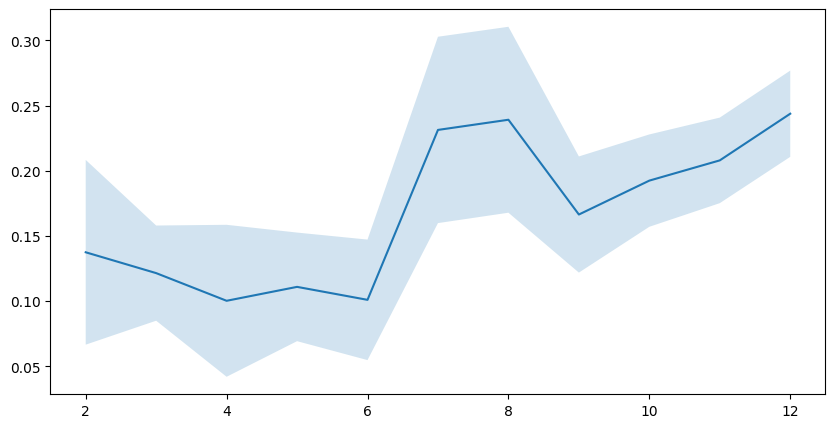

In [3]:
# Define the parameters of the simulation
codelife = 5
unit_sales_per_day = 4
units_per_case = 4
lead_times = np.arange(2, 13)

# Define how many days we're going to simulate for. Reduce the number of days to speed up the simulation.
total_days = 4000

min_loss = np.zeros(len(lead_times))
min_loss_std = np.zeros(len(lead_times))

for i, lead_time in enumerate(lead_times):
    print(f"Lead time: {lead_time}")
    simulation = LossSimulation(
        codelife=codelife,
        unit_sales_per_day=unit_sales_per_day,
        units_per_case=units_per_case,
        lead_time=lead_time,
    )

    min_loss[i], min_loss_std[i] = simulation.calculate_min_loss_and_variance(1000, lead_time)

# Plot the results, with the variance as a shaded area
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lead_times, min_loss)
ax.fill_between(lead_times, min_loss - min_loss_std, min_loss + min_loss_std, alpha=0.2)
plt.xlabel("Lead time")
plt.ylabel("Minimum loss")
plt.title("Impact of lead time on loss")
plt.show()

### Impact of units per case on loss

We've come so far, why not complete the set? Again the parameters are important here. We need to have something with low CICL (cases sold in the code life of the product) to see the impact of this, otherwise the impact isn't that important. Generally we find that as the CICL gets higher, and is above 1, then the theoretical best case is essentially zero loss.

Units per case: 1
Units per case: 2
Units per case: 3
Units per case: 4
Units per case: 5
Units per case: 6
Units per case: 7
Units per case: 8
Units per case: 9
Units per case: 10
Units per case: 11
Units per case: 12


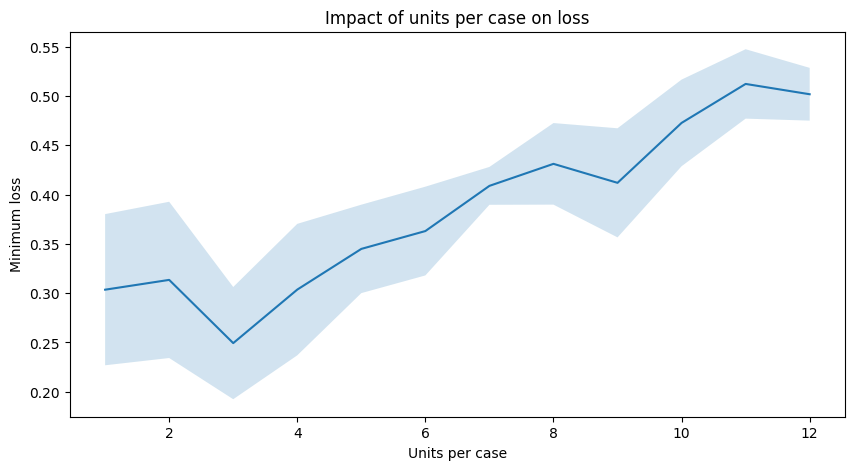

In [11]:
# Define the parameters of the simulation
codelife = 3
unit_sales_per_day = 2
units_per_case_array = np.arange(1, 13)
lead_time = 3

# Define how many days we're going to simulate for. Reduce the number of days to speed up the simulation.
total_days = 4000

min_loss = np.zeros(len(units_per_case_array))
min_loss_std = np.zeros(len(units_per_case_array))

for i, units_per_case in enumerate(units_per_case_array):
    print(f"Units per case: {units_per_case}")
    simulation = LossSimulation(
        codelife=codelife,
        unit_sales_per_day=unit_sales_per_day,
        units_per_case=units_per_case,
        lead_time=lead_time,
    )

    min_loss[i], min_loss_std[i] = simulation.calculate_min_loss_and_variance(1000, lead_time)

# Plot the results, with the variance as a shaded area
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(units_per_case_array, min_loss)
ax.fill_between(units_per_case_array, min_loss - min_loss_std, min_loss + min_loss_std, alpha=0.2)
plt.xlabel("Units per case")
plt.ylabel("Minimum loss")
plt.title("Impact of units per case on loss")
plt.show()

Okay, so that's pretty standard. What else is possible? Part of the answer to this question is that you should really have an explore yourself. But we'll do something a bit more interesting by exploring some of the other APIs that are explosed in the `LossSimulation` class. Let's see how the average eod stock level varies with the stockout threshold. 

As a reminder, the stockout threshold defines the probability of a stockout which we're willing to accept. If the probability of a stockout is higher than that, we'll order another case until it's below the threshold. If the probability of a stockout is lower than that, we'll stop ordering and wait till more stock has been sold or more stock arrives. That sort of thing.

Stockout threshold: 0.01
Stockout threshold: 0.11888888888888888
Stockout threshold: 0.22777777777777777
Stockout threshold: 0.33666666666666667
Stockout threshold: 0.44555555555555554
Stockout threshold: 0.5544444444444444
Stockout threshold: 0.6633333333333333
Stockout threshold: 0.7722222222222221
Stockout threshold: 0.8811111111111111
Stockout threshold: 0.99


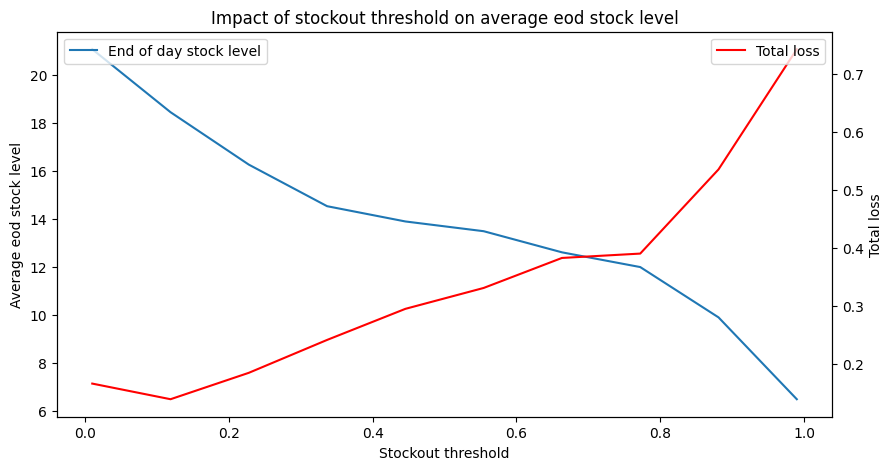

In [22]:
# Let's take a classic simulation and set of characteristics.

simulation = LossSimulation(
    codelife=3,
    unit_sales_per_day=4,
    units_per_case=4,
    lead_time=3,
)

total_days = 1000

# Now we're defining the ranges of stockout thresholds that we can explore. Note how we don't go all the way to zero here, because we're never going to get to a precisely zero stockout probability (there's always a chance of someone coming in at the last minute and buying loads of stuff). Likewise we don't want to go all the way to one. Lots of this are for numerical stability reasons as well. Try changing it, python will shout at you.
stockout_threshold_array = np.linspace(0.01, 0.99, 10)

availability_loss = np.zeros(len(stockout_threshold_array))
waste_loss = np.zeros(len(stockout_threshold_array))
units_sold = np.zeros(len(stockout_threshold_array))
eod_units = np.zeros(len(stockout_threshold_array))

for i, stockout_threshold in enumerate(stockout_threshold_array):
    print(f"Stockout threshold: {stockout_threshold}")
    simulation_result = simulation.simulate(total_days, stockout_threshold)
    
    availability_loss[i] = np.sum(simulation_result.stockout) / len(simulation_result.stockout)
    waste_loss[i] = (
        np.sum(simulation_result.wasted_units) / np.sum(simulation_result.cases_ordered) / simulation.units_per_case
    )
    units_sold[i] = np.mean(simulation_result.units_sold)
    eod_units[i] = np.mean(simulation_result.eod_units)

total_loss = availability_loss + waste_loss


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(stockout_threshold_array, eod_units, label="End of day stock level")
ax2 = ax.twinx()
ax2.plot(stockout_threshold_array, total_loss, label="Total loss", color='red')
ax2.set_ylabel('Total loss')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel("Stockout threshold")
ax.set_ylabel("Average eod stock level")
ax.set_title("Impact of stockout threshold on average eod stock level")
plt.show()

Hopefully this has given you a bit of a taste of what is possible with the humble `shopping_simulator` package. Using this theoretical framework, we can begin to explore some of the more complex questions in supply chain management. Best of luck where it takes you.